In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import numpy as np 
import torch 
import metatensor 
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64)
from metatensor import load 
from mlelec.utils.twocenter_utils import _to_coupled_basis, _to_uncoupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks 

In [3]:
from metatensor import Labels, TensorBlock, TensorMap
from mlelec.data.dataset import PySCFPeriodicDataset
from mlelec.utils.twocenter_utils import fix_orbital_order

/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.size'] = 14

In [5]:
orbitals = {'sto-3g': {6: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]],
                      5: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]],
                      7: [[1,0,0],[2,0,0],[2,1,1], [2,1,-1],[2,1,0]]}, 
            'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]}}

In [6]:
def get_targets(dataset, device ="cpu", cutoff = None, target='fock'):
    if target.lower() == 'fock':
        matrices_negative = dataset._fock_realspace_negative_translations
    elif target.lower() == 'overlap':
        matrices_negative = dataset._overlap_realspace_negative_translations
    else: 
        raise ValueError('target must be fock or overlap')
    blocks = matrix_to_blocks(dataset, matrices_negative , device = 'cpu', cutoff = cutoff, all_pairs = True, target= target)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.keys_to_samples('cell_shift_a')
    blocks = blocks.keys_to_samples('cell_shift_b')
    blocks = blocks.keys_to_samples('cell_shift_c')

    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_a')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_b')
    coupled_blocks = coupled_blocks.keys_to_samples('cell_shift_c')
    return blocks , coupled_blocks

In [21]:
from mlelec.models.linear import LinearModelPeriodic
device='cpu'
def train_ridge(model, target_blocks, set_bias=False, kernel_ridge = False, alphas = None, alpha = 1e-9, cv = 3):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha, cv =cv)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

In [8]:
def renumber_samples(tmap): 
    """When slicing tensormaps, this function can be used to renumber the samples starting from zero """
    blocks= []
    for k, b in tmap.items():
        val = b.samples.values.copy()
        _to_subtract = val[:,0][0]
        val[:,0]-=_to_subtract # sets the target coupled blocks starting from 0 # asumming the structure idx in test blocks is sequential
        samples = Labels(b.samples.names, val)
        blocks.append(TensorBlock(values = b.values,
                                 samples = samples,
                                 components = b.components,
                                 properties = b.properties))
    return TensorMap(tmap.keys, blocks)

In [9]:
from metatensor import slice as mts_slice
from mlelec.utils.pbc_utils import blocks_to_matrix

In [10]:
def error_blocks(pred:TensorMap, target:TensorMap):
    assert pred.keys == target.keys
    block_loss = {}
    for (tk, tb), (pk,pb) in zip(target.items(), pred.items()):
        nsamples = len(tb.samples)
        ncomponents = len(tb.components)
        block_loss[tuple(tk)] = torch.norm(tb.values -pb.values)/(nsamples*ncomponents)    
    return block_loss
    
def error_matrix(pred:TensorMap, target:TensorMap, dataset):
    # assume passing coupled blocks for now 
    # SUPERSLOW! 
    Hpred = blocks_to_matrix(_to_uncoupled_basis(target), dataset)
    Htarget = blocks_to_matrix(_to_uncoupled_basis(pred), dataset)
    assert len(Hpred) == len(Htarget)
    loss = 0
    print(len(Hpred))
    for ifr in range(len(Hpred)):
        ntranslations = len(Hpred[ifr])
        for T,pred_mat in Hpred[ifr].items():
            assert pred_mat.shape[0] == pred_mat.shape[1]
            nelements = np.prod(pred_mat.shape)
            loss += torch.norm(pred_mat - Htarget[ifr][T])**2 /nelements
        loss = loss/ntranslations
    loss = loss/(len(Hpred))
    return torch.sqrt(loss)

# c2 174

In [11]:
workdir = '/home/nigam/scratch/MAC/k-hamiltonian/'
root = f'{workdir}/examples/data/periodic/c2/'
ORBS = 'sto-3g'
START = 0
STOP = 174
NTRAIN = 150
frames = read(f'{root}/C2_174.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = True

kmesh = [8,8,1]
kfock = [np.load(f"{root}/results_C2_174_881/fock_{i}_881.npy") for i in range(START, STOP)]
kover = [np.load(f"{root}/results_C2_174_881/over_{i}_881.npy") for i in range(START, STOP)]
for ifr in range(len(frames)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock, overlap_kspace = kover, device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

In [12]:
cutoff = 6
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)

# train_lbl = Labels(["structure"], values= np.array(list(range(NTRAIN))).reshape(-1,1))
# test_lbl= Labels(["structure"], values= np.array(list(range(NTRAIN,NSTOP))).reshape(-1,1))
# target_train = mts_slice(target_coupled_blocks, 'samples', train_lbl)
# target_test = mts_slice(target_coupled_blocks, 'samples', test_lbl)

In [14]:
trainfrac = [1,5,10,25,50,100]

In [15]:
root = 'train_results/c2/cosmosrv_12.03/'
prediction_test = {tf:load(f'{root}/predictions_test_tf{tf}.npz').to(arrays='torch') for tf in trainfrac}
prediction_train = {tf:load(f'{root}/predictions_train_tf{tf}.npz').to(arrays='torch') for tf in trainfrac}

In [19]:
dataset_test = PySCFPeriodicDataset(frames = frames[NTRAIN:], kmesh = kmesh, fock_kspace = kfock[NTRAIN:], overlap_kspace = kover[NTRAIN:], device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)
_, target_test = get_targets(dataset_test, cutoff=cutoff)
block_loss = {}
matrix_loss = {}
for tf in prediction_test:
    prediction_test[tf] = renumber_samples(prediction_test[tf])
    block_loss[tf] = error_blocks(prediction_test[tf], target_test)
    matrix_loss[tf] = error_matrix(prediction_test[tf], target_test, dataset_test)

24
24
24
24
24
24


In [20]:
block_loss_train = {}
matrix_loss_train = {}
for tf in prediction_train:
    dataset_tf = PySCFPeriodicDataset(frames = frames[:tf], kmesh = kmesh, fock_kspace = kfock[:tf], overlap_kspace = kover[:tf], device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)
    train_lbl_tf = Labels(["structure"], values= np.array(list(range(tf))).reshape(-1,1))
    _, target_train_tf =  get_targets(dataset_tf, cutoff = cutoff)
    # mts_slice(target_coupled_blocks, 'samples', train_lbl_tf)
    # prediction_train[tf] = renumber_samples(prediction_train[tf])
    block_loss_train[tf] = error_blocks(prediction_train[tf], target_train_tf)
    matrix_loss_train[tf] = error_matrix(prediction_train[tf], target_train_tf, dataset_tf)

1
5
10
25
50
100


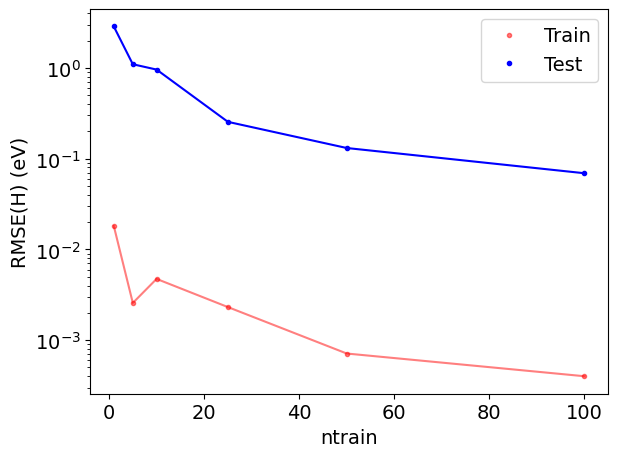

In [21]:
from ase.units import Hartree
plt.plot(trainfrac, np.array(list(matrix_loss_train.values()))*Hartree, 'r-', alpha = 0.5)
plt.plot(trainfrac, np.array(list(matrix_loss_train.values()))*Hartree, 'r.', alpha = 0.5, label= 'Train')

plt.plot(trainfrac, np.array(list(matrix_loss.values()))*Hartree, 'b-')
plt.plot(trainfrac, np.array(list(matrix_loss.values()))*Hartree, 'b.', label= 'Test')

plt.yscale('log')
# plt.xscale('log')
plt.ylabel('RMSE(H) (eV)')
plt.xlabel('ntrain')
plt.legend()
plt.tight_layout()
plt.savefig('LC_C2.png')

## predicted band structure 

In [32]:
tf = 10
predicted_matrices = blocks_to_matrix(prediction_test[tf], dataset_test)

/tmp/ipykernel_231987/288265819.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


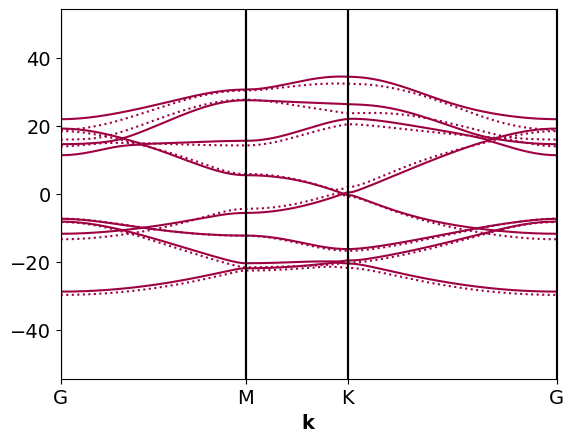

In [33]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')



target_blocks_test, target_coupled_blocks_test = get_targets(dataset_test, cutoff = cutoff)
target_blocks_over, target_coupled_blocks_over = get_targets(dataset_test, cutoff = cutoff, target='overlap')

reconstructed_H = blocks_to_matrix(target_blocks_test, dataset_test)
reconstructed_S = blocks_to_matrix(target_blocks_over, dataset)


ifr = 20
frame = dataset_test.structures[ifr]
pyscf_cell = dataset_test.cells[ifr]
kmesh = dataset_test.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])

actual_fock = np.asarray(list(reconstructed_H[ifr].values()))
predicted_fock = np.asarray(list(predicted_matrices[ifr].values()))
realover = np.asarray(list(reconstructed_S[ifr].values()))


ax, b = plot_bands_frame_(frame, predicted_fock, realover, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = cmap(0))
ax, b = plot_bands_frame_(frame, actual_fock, realover, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = cmap(0), ls= ':')

In [34]:
fig.tight_layout()
fig.savefig('predicted_bands_c2_onestructure_tf10.png')

# Bands as a function of cutoff 

In [ ]:
cutoff = 6
# target_blocks_nc, target_coupled_blocks_nc = get_targets(dataset, cutoff = None)
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)

# target_blocks_nc_over, target_coupled_blocks_nc_over = get_targets(dataset, cutoff = None, target='overlap')
# target_blocks_over, target_coupled_blocks_over = get_targets(dataset, cutoff = cutoff, target='overlap')

In [ ]:
reconstructed_H = blocks_to_matrix(target_blocks, dataset)
reconstructed_S = blocks_to_matrix(target_blocks_over, dataset)

# reconstructed_H_nc = blocks_to_matrix(target_blocks_nc, dataset)
# reconstructed_S_nc = blocks_to_matrix(target_blocks_nc_over, dataset)

/tmp/ipykernel_223779/3947213395.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')
/tmp/ipykernel_223779/3947213395.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


IndexError: list index out of range

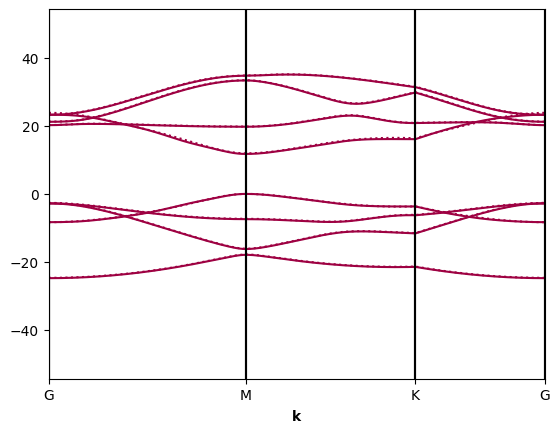

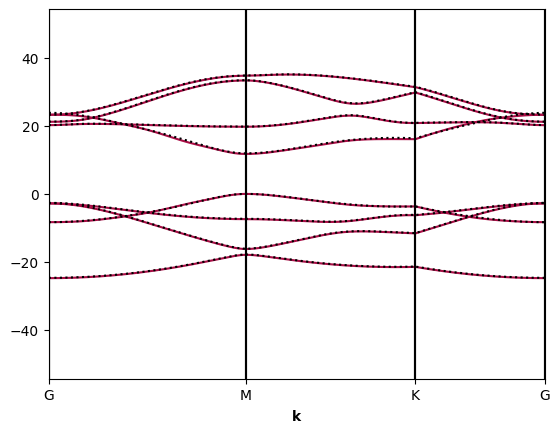

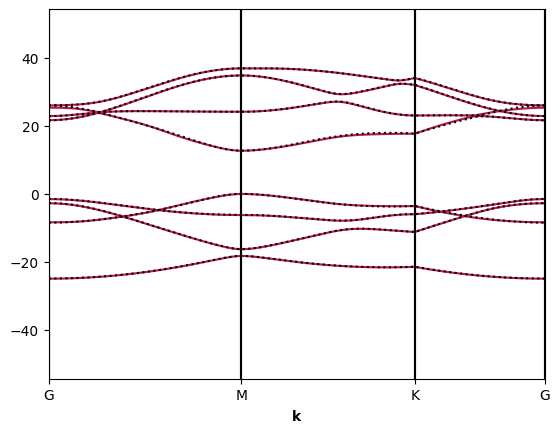

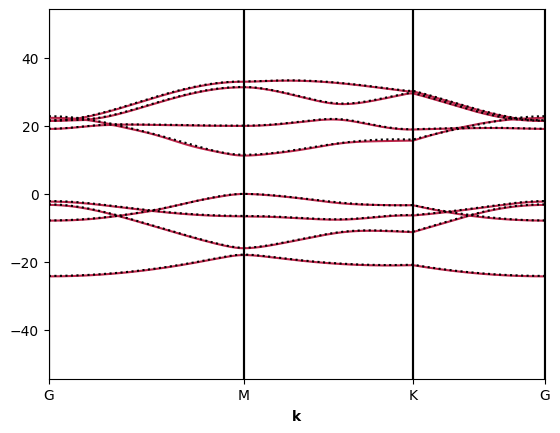

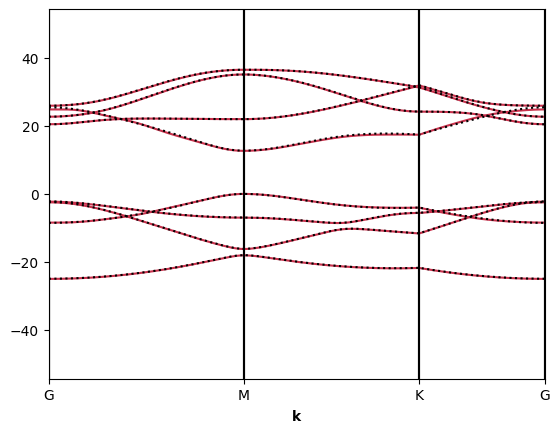

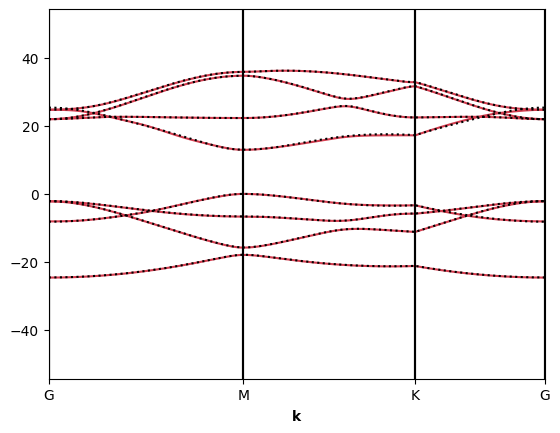

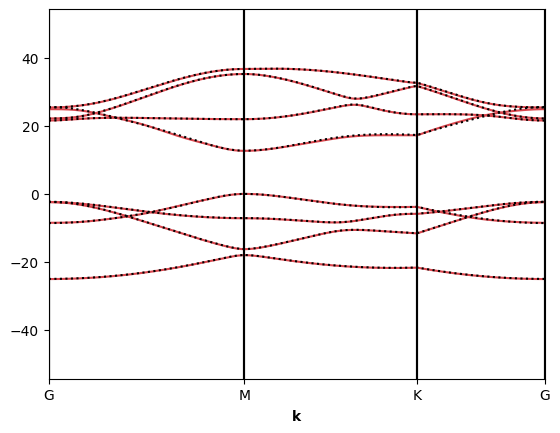

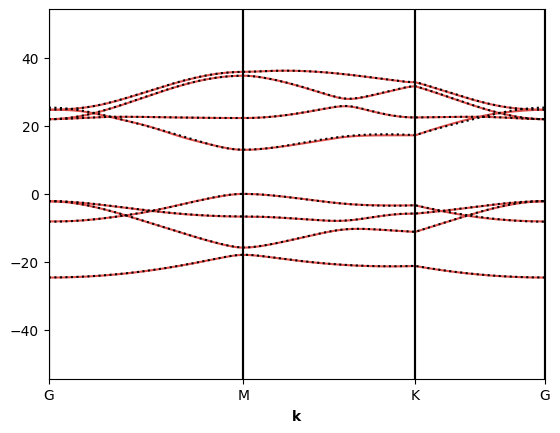

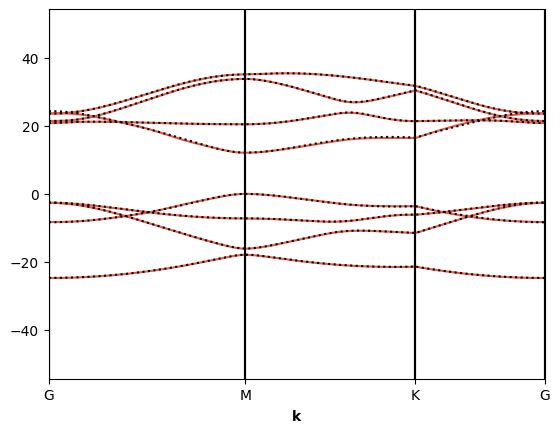

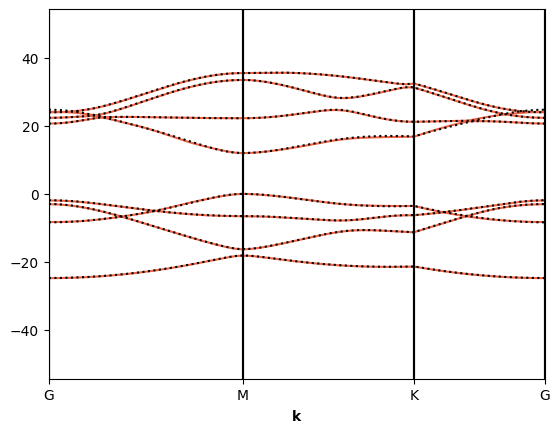

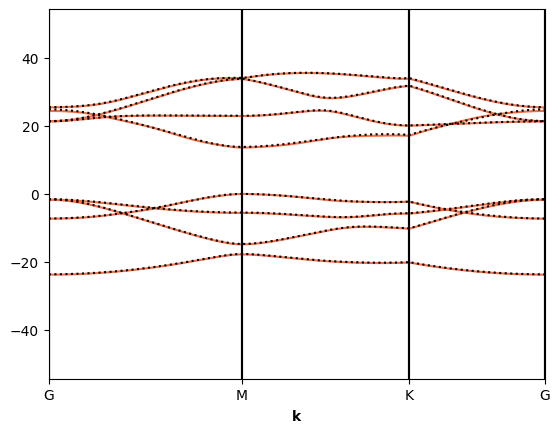

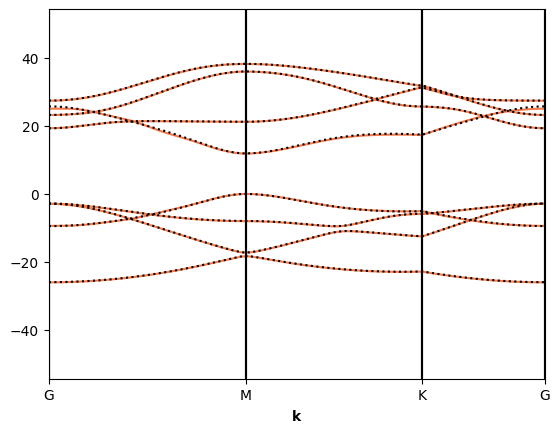

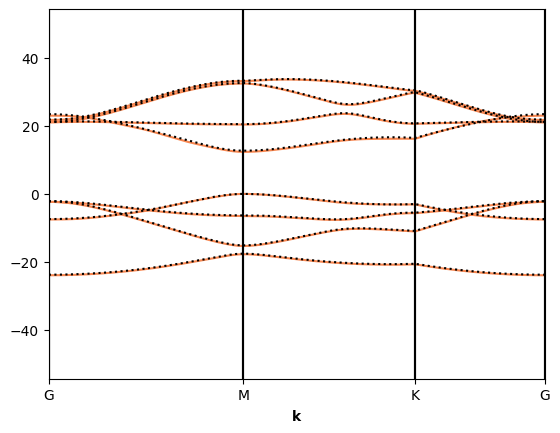

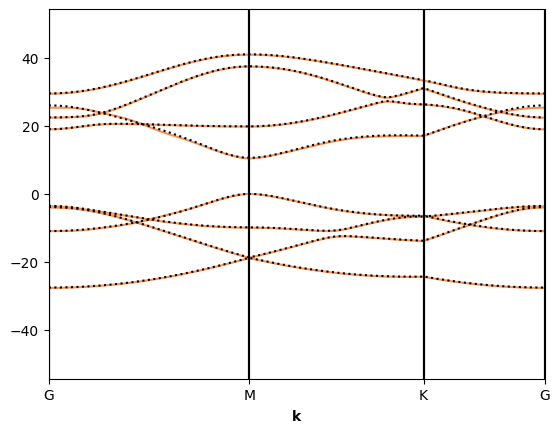

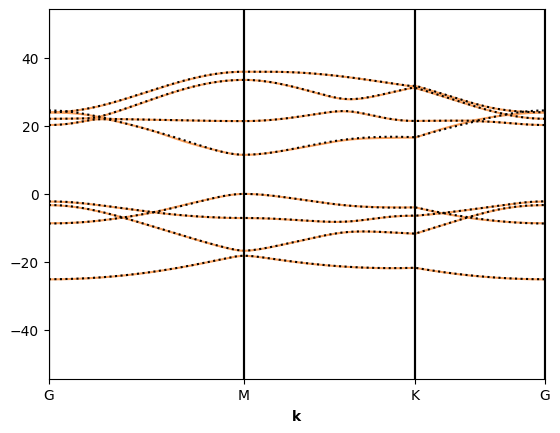

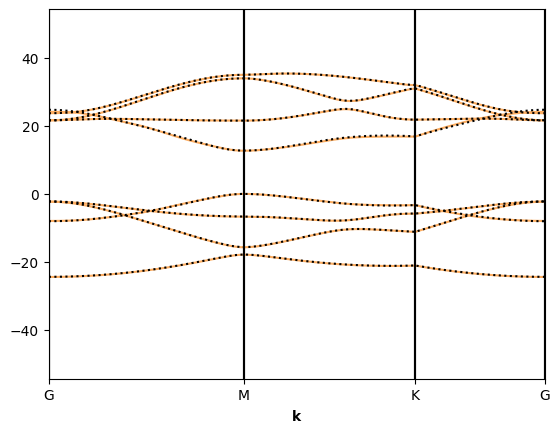

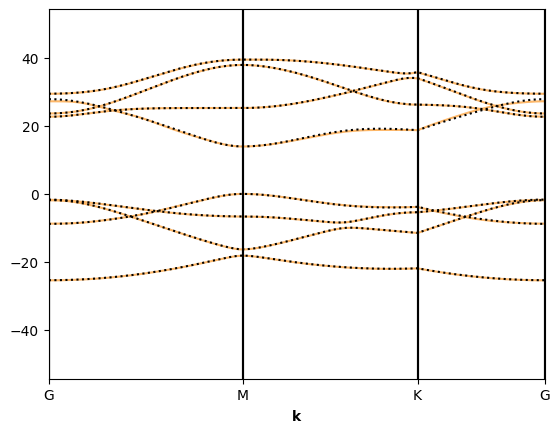

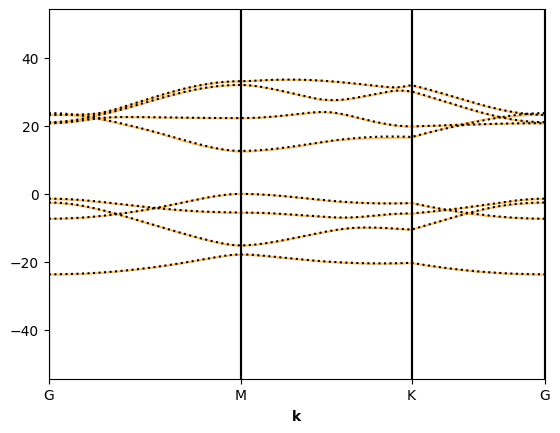

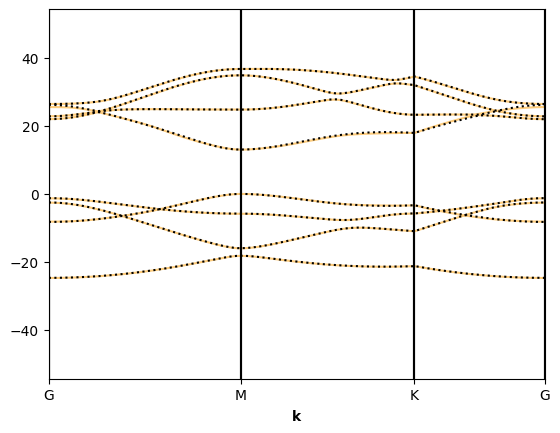

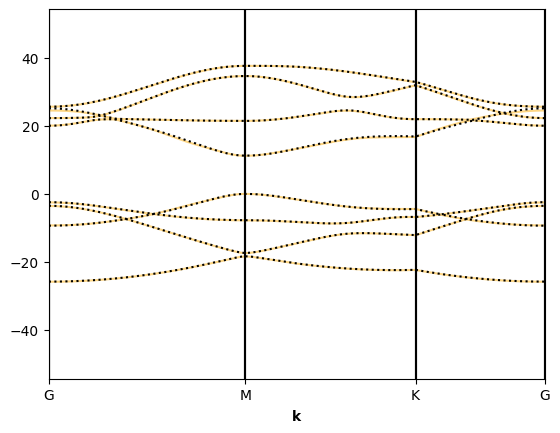

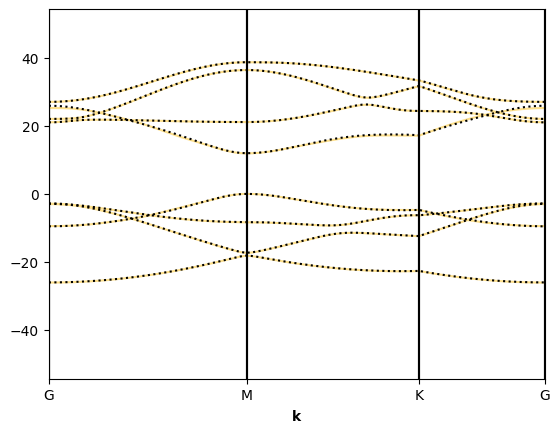

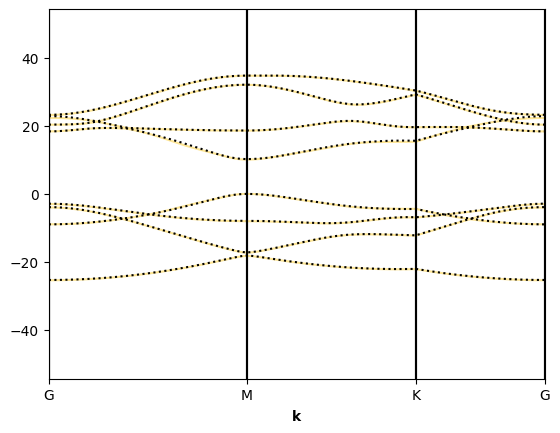

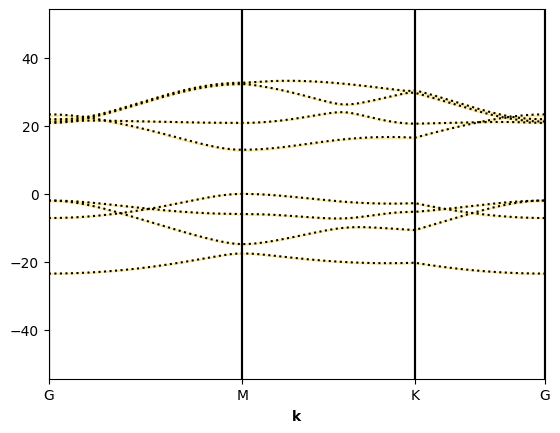

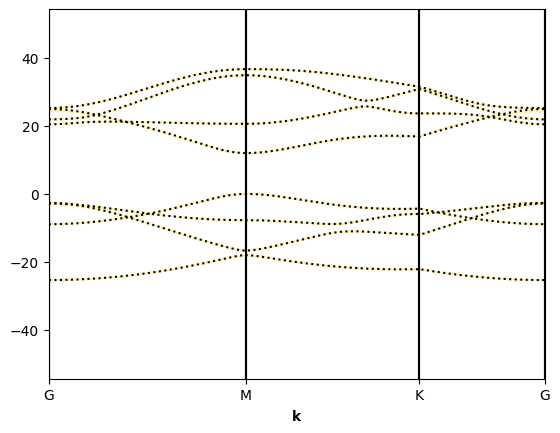

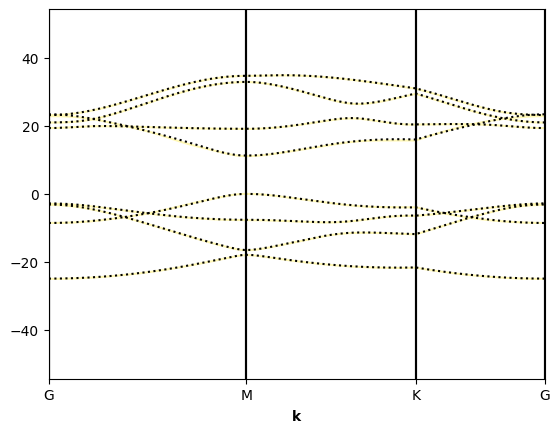

In [9]:
fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')


ifr = 0
frame = dataset.structures[ifr]
pyscf_cell = dataset.cells[ifr]
kmesh = dataset.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
realfock = np.asarray(list(dataset.fock_realspace[0].values()))
realover = np.asarray(list(dataset.overlap_realspace[0].values()))

realfock_cutoff = np.asarray(list(reconstructed_H[0].values()))
realover_cutoff = np.asarray(list(reconstructed_S[0].values()))

ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = cmap(0))
ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = cmap(0), ls= ':')


nmax = 50
for ifr in range(0, nmax):
    frame = dataset.structures[ifr]
    pyscf_cell = dataset.cells[ifr]
    kmesh = dataset.kmesh[ifr]
    kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])
    realfock = np.asarray(list(dataset.fock_realspace[ifr].values()))
    realover = np.asarray(list(dataset.overlap_realspace[ifr].values()))
    realfock_cutoff = np.asarray(list(reconstructed_H[ifr].values()))
    realover_cutoff = np.asarray(list(reconstructed_S[ifr].values()))
    fig, ax = plt.subplots()
    ax, b = plot_bands_frame_(frame, realfock, realover, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
                              kpath = kpath, ax=ax,color = cmap((ifr+1)/nmax))
    ax, b = plot_bands_frame_(frame, realfock_cutoff, realover_cutoff, pyscf_cell, kmesh = [8,8,1], special_symm = 'hexagonal' , 
                              kpath = kpath, ax = ax, color = 'k', ls = ':')



# BN

In [11]:
workdir = '/home/nigam/scratch/MAC/k-hamiltonian/'
root = f'{workdir}/examples/data/periodic/BN/'
ORBS = 'sto-3g'
START = 0
STOP = 100
NTRAIN = 80
frames = read(f'{root}/single_BN_sheet_vac.extxyz', slice(START, STOP))
for f in frames: 
    f.pbc = True

kmesh = [8,8,1]
kfock = [np.load(f"{root}/fock_{i}_881.npy") for i in range(START, STOP)]
kover = [np.load(f"{root}/over_{i}_881.npy") for i in range(START, STOP)]
for ifr in range(len(frames)):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frames[ifr], orbitals[ORBS]) #### TODO <<
        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frames[ifr], orbitals[ORBS]) #### TODO <<

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock, overlap_kspace = kover, device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

In [12]:
cutoff = 6
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)

In [13]:
# train_lbl = Labels(["structure"], values= np.array(list(range(80))).reshape(-1,1))
# test_lbl= Labels(["structure"], values= np.array(list(range(80,100))).reshape(-1,1))
# target_train = mts_slice(target_coupled_blocks, 'samples', train_lbl)
# target_test = mts_slice(target_coupled_blocks, 'samples', test_lbl)
# target_test

In [14]:
trainfrac = [1,5,10,25,40, 50, 80]

In [15]:
root = 'train_results/BN100/imxsrv_12.03/'
prediction_test = {tf:load(f'{root}/predictions_test_tf{tf}.npz').to(arrays='torch') for tf in trainfrac}
prediction_train = {tf:load(f'{root}/predictions_train_tf{tf}.npz').to(arrays='torch') for tf in trainfrac}

In [16]:
dataset_test = PySCFPeriodicDataset(frames = frames[NTRAIN:], kmesh = kmesh, fock_kspace = kfock[NTRAIN:], overlap_kspace = kover[NTRAIN:], device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)
_, target_test = get_targets(dataset_test, cutoff=cutoff)
block_loss = {}
matrix_loss = {}
for tf in prediction_test:
    prediction_test[tf] = renumber_samples(prediction_test[tf])
    block_loss[tf] = error_blocks(prediction_test[tf], target_test)
    matrix_loss[tf] = error_matrix(prediction_test[tf], target_test, dataset_test)

20
20
20
20
20
20
20


In [17]:
block_loss_train = {}
matrix_loss_train = {}
for tf in prediction_train:
    dataset_tf = PySCFPeriodicDataset(frames = frames[:tf], kmesh = kmesh, fock_kspace = kfock[:tf], overlap_kspace = kover[:tf], device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)
    train_lbl_tf = Labels(["structure"], values= np.array(list(range(tf))).reshape(-1,1))
    _, target_train_tf =  get_targets(dataset_tf, cutoff = cutoff)
    # mts_slice(target_coupled_blocks, 'samples', train_lbl_tf)
    prediction_train[tf] = renumber_samples(prediction_train[tf])
    block_loss_train[tf] = error_blocks(prediction_train[tf], target_train_tf)
    matrix_loss_train[tf] = error_matrix(prediction_train[tf], target_train_tf, dataset_tf)

1
5
10
25


KeyboardInterrupt: 

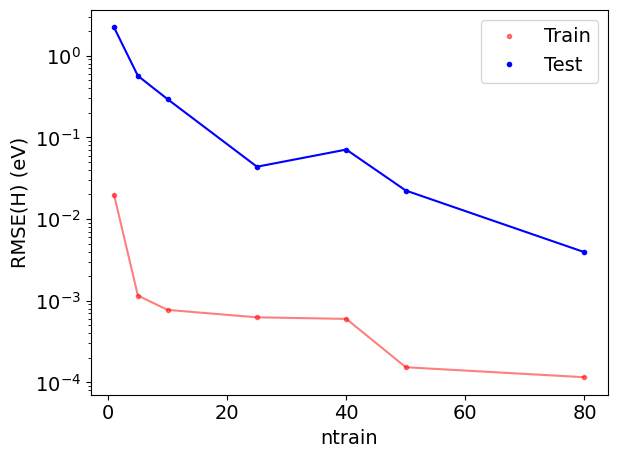

In [21]:
from ase.units import Hartree
plt.plot(trainfrac, np.array(list(matrix_loss_train.values()))*Hartree, 'r-', alpha = 0.5)
plt.plot(trainfrac, np.array(list(matrix_loss_train.values()))*Hartree, 'r.', alpha = 0.5, label= 'Train')

plt.plot(trainfrac, np.array(list(matrix_loss.values()))*Hartree, 'b-')
plt.plot(trainfrac, np.array(list(matrix_loss.values()))*Hartree, 'b.', label= 'Test')

plt.yscale('log')
# plt.xscale('log')
plt.ylabel('RMSE(H) (eV)')
plt.xlabel('ntrain')
plt.legend()
plt.tight_layout()
# plt.savefig('LC_BN.png')

In [22]:
tf = 80
predicted_matrices = blocks_to_matrix(prediction_test[tf], dataset_test)

/tmp/ipykernel_237369/879814077.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


Text(0, 0.5, 'Band energy ($\\epsilon_\\mathbf{k} -  $\\epsilon_F) (eV)')

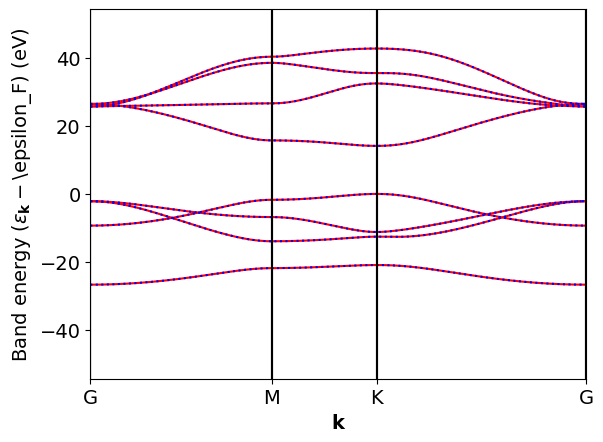

In [26]:


target_blocks_test, target_coupled_blocks_test = get_targets(dataset_test, cutoff = cutoff)
target_blocks_over, target_coupled_blocks_over = get_targets(dataset_test, cutoff = cutoff, target='overlap')

reconstructed_H = blocks_to_matrix(target_blocks_test, dataset_test)
reconstructed_S = blocks_to_matrix(target_blocks_over, dataset)



/tmp/ipykernel_237369/986445271.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Spectral')


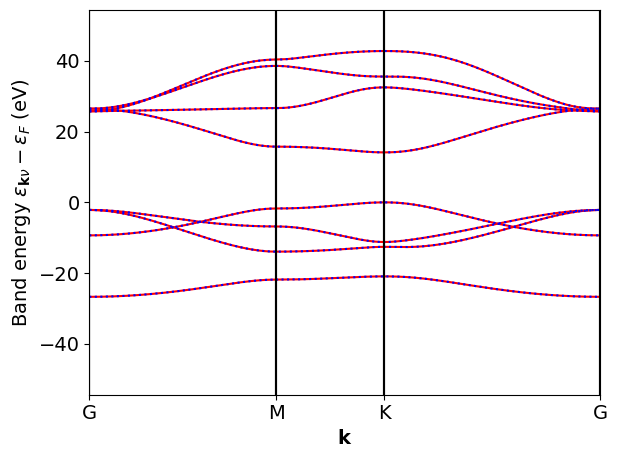

In [32]:

fig, ax = plt.subplots()

special_points = {'G': [0.0, 0.0, 0.0], 'K': [0.3333333333333333, 0.3333333333333333, 0.0], 'M': [0.5, 0.0, 0.0]}

from mlelec.utils.plot_utils import plot_bands_frame_
import matplotlib

cmap = matplotlib.cm.get_cmap('Spectral')
ifr = 0
frame = dataset_test.structures[ifr]
pyscf_cell = dataset_test.cells[ifr]
kmesh = dataset_test.kmesh[ifr]
kpath = frame.cell.bandpath('GMKG', 500, special_points = special_points, pbc = [True, True, False])

actual_fock = np.asarray(list(reconstructed_H[ifr].values()))
predicted_fock = np.asarray(list(predicted_matrices[ifr].values()))
realover = np.asarray(list(reconstructed_S[ifr].values()))


ax, b = plot_bands_frame_(frame, actual_fock, realover, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = 'r', ls= '-')
ax, b = plot_bands_frame_(frame, predicted_fock, realover, pyscf_cell, [8,8,1], special_symm = 'hexagonal', kpath = kpath, ax = ax, color = 'b', ls=':')

ax.set_ylabel(r'Band energy $\epsilon_{\mathbf{k} \nu} -  \epsilon_F$ (eV)')
fig.set_tight_layout(True)
fig.savefig('predicted_bands_BN_onestructure_tf80.png')

# Graphene variety 

In [11]:
root = 'examples/data/periodic/graphene_supercell_variety'
ORBS = 'sto-3g'
frames = read(f'{root}/graphene_variety.xyz', '1:3')
for f in frames: 
    f.pbc = True

# kmesh = [[4,7,1],[8,8,1],[4,4,1],[3,3,1],[4,3,1]]
kmesh = [[8,8,1],[4,4,1]]

# names = ['ortho', 'hex', 'hex22', 'hex33', 'hex23']
names = ['hex', 'hex22']
factor = [frame.get_global_number_of_atoms()* np.sqrt(np.prod(ikmesh)) for frame, ikmesh in zip(frames, kmesh)]
kfock = [np.load(f"{root}/new/fock_{name}_{''.join(map(str, ikmesh))}.npy") for name, ikmesh in zip(names, kmesh)]
kover =[np.load(f"{root}/new/over_{name}_{''.join(map(str, ikmesh))}.npy") for name, ikmesh in zip(names, kmesh)]

for ifr, frame in enumerate(frames):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frame, orbitals[ORBS]) #### TODO <<
        kfock[ifr][ik]*=factor[ifr]

        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frame, orbitals[ORBS]) #### TODO <<
        kover[ifr][ik]*=factor[ifr]
dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock, overlap_kspace = kover, device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

In [12]:
# from ase.visualize.plot import plot_atoms
# from matplotlib import pyplot as plt
# fig, ax = plt.subplots()
# plot_atoms(frames[0], ax = ax, radii = [0.5,0.5])
# ax.axis('off')
# fig.savefig('hex.png')
# fig, ax = plt.subplots()
# plot_atoms(frames[1], ax = ax, radii = [0.5]*8)
# ax.axis('off')
# fig.savefig('hex22.png')


## Train one 

In [13]:
cutoff = None
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)#, target='overlap')

In [19]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

hypers_pair = {'cutoff': 12,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.6,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = True,
                      kmesh = dataset.kmesh, device="cpu", lcut = LCUT, return_rho0ij = return_rho0ij, counter = dataset._translation_counter, 
                      T_dict = dataset._translation_dict)

if both_centers and not return_rho0ij:
    NU = 3
else:
    NU = 2
rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = 'cpu',
                                feature_names = rhoij.property_names)

hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = True)

{'cutoff': 12, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.6, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:148: UserWarning: Using kmesh [[8, 8, 1], [4, 4, 1]] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


In [20]:
train_lbl = Labels(["structure"], values= np.array([[0]]).reshape(-1,1))
test_lbl= Labels(["structure"], values= np.array([[1]]).reshape(-1,1))
hfeat_train = mts_slice(hfeat, 'samples', train_lbl)
hfeat_test = mts_slice(hfeat, 'samples', test_lbl)
target_train = mts_slice(target_coupled_blocks, 'samples', train_lbl)
target_test = mts_slice(target_coupled_blocks, 'samples', test_lbl)

dataset_hex = PySCFPeriodicDataset(frames = [frames[0]], kmesh = [8,8,1], fock_kspace = [kfock[0]], overlap_kspace = [kover[0]], device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)
dataset_hex22 = PySCFPeriodicDataset(frames = [frames[1]], kmesh = [4,4,1], fock_kspace = [kfock[1]], overlap_kspace = [kover[1]], device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)


In [23]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_train, 
                                  target_blocks = target_train,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
alpha = 1e-7
alphas = np.logspace(-10,1,25)
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_train,
                                                                         set_bias = True,
                                                                         alpha = alpha, 
                                                                         alphas = alphas
                                                                        )
print(loss_ridge_bias)

tensor(0.8919)


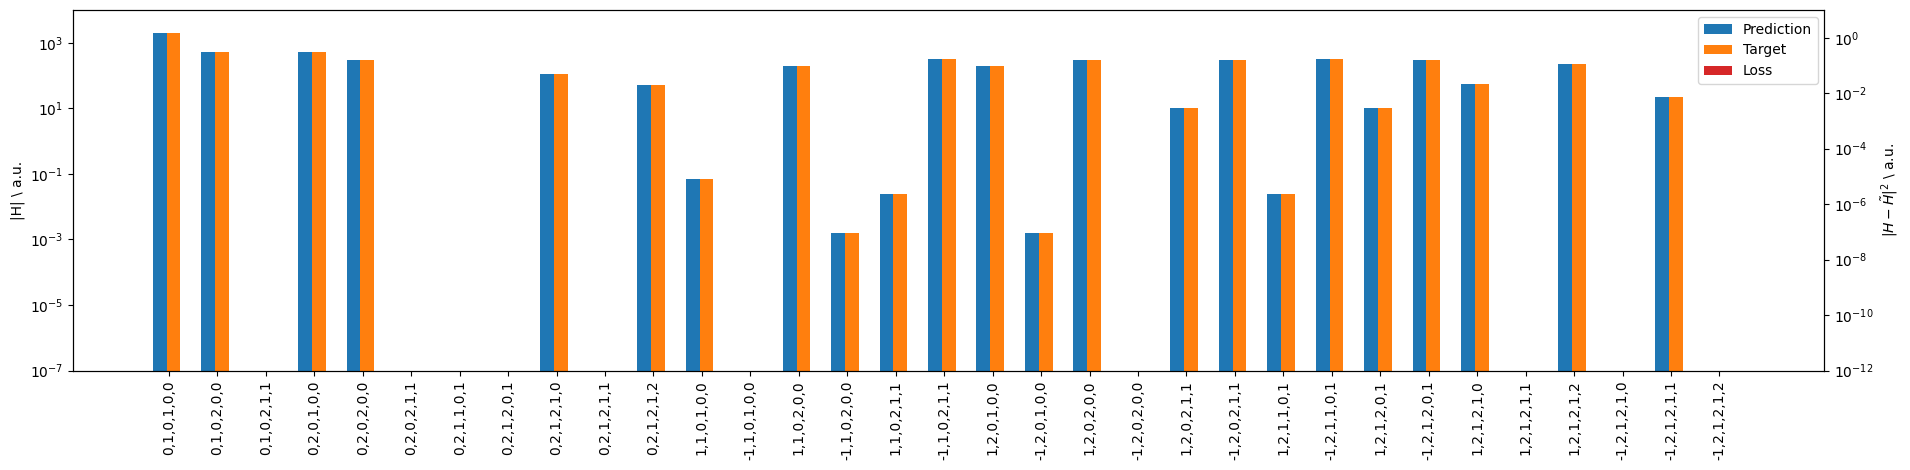

In [16]:
from mlelec.utils.plot_utils import plot_block_errors

fig, ax, ax_loss = plot_block_errors(target_train, pred_ridge_bias, plot_loss=True)
ax.set_ylim(1e-7, 1e4)
ax_loss.set_ylim(1e-12, 1e1)
fig.set_tight_layout(tight=True)
fig.savefig('blockerrors_hex_train.png')

In [17]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
pred_blocks = []
dummy_property = target_coupled_blocks[0].properties
targetkeynames = target_coupled_blocks.keys.names

for imdl, (key, tkey) in enumerate(zip(model_ridge.model, target_test.keys )):
    target = target_test.block(tkey)
    nsamples, ncomp, nprops = target.values.shape

    feat = map_targetkeys_to_featkeys(hfeat_test, tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = ridges_bias[imdl].predict(x) # kernel ridge automatically computes the kernel
    assert np.all(feat.samples.values[:,:6] == target.samples.values), (feat.samples.values[:,:6], target.samples.values)
    pred_blocks.append(
                    TensorBlock(
                        values = torch.from_numpy(pred.reshape((nsamples, ncomp, 1))).to(device),
                        samples = target.samples,
                        components = target.components,
                        properties = dummy_property,
                        )
    )

pred = TensorMap(target_test.keys, pred_blocks)
blocks= []
for k, b in pred.items():
    val = b.samples.values.copy()
    _to_subtract = val[:,0][0]
    val[:,0]-=_to_subtract # sets the target coupled blocks starting from 0 # asumming the structure idx in test blocks is sequential
    samples = Labels(b.samples.names, val)
    blocks.append(TensorBlock(values = b.values,
                             samples = samples,
                             components = b.components,
                             properties = b.properties))
pred = TensorMap(pred.keys, blocks)

In [18]:
loss = {}
for (k, tb) in target_test.items():
        feat = map_targetkeys_to_featkeys(hfeat_test, k)
        loss[tuple(k)]= torch.norm(tb.values - pred.block(k).values)**2
        print(' '.join([f'{key:>2d}' for key in k.values]), f'f: {torch.linalg.norm(feat.values):>10.6f} | \
        t: {torch.norm(tb.values):>10.6f} | loss: {torch.sum((tb.values - pred.block(k).values)**2):>10.6f}' )

print('LOSS:', sum(loss.values()))


 0  6  1  0  6  1  0  0 f:   8.104396 |         t: 3992.577724 | loss:   0.000000
 0  6  1  0  6  2  0  0 f:   8.104396 |         t: 1076.336337 | loss:   0.000000
 0  6  1  0  6  2  1  1 f:   0.000000 |         t:   0.000000 | loss:   0.000000
 0  6  2  0  6  1  0  0 f:   8.104396 |         t: 1076.336337 | loss:   0.000000
 0  6  2  0  6  2  0  0 f:   8.104396 |         t: 592.550734 | loss:   0.000001
 0  6  2  0  6  2  1  1 f:   0.000000 |         t:   0.000001 | loss:   0.000000
 0  6  2  1  6  1  0  1 f:   0.000000 |         t:   0.000000 | loss:   0.000000
 0  6  2  1  6  2  0  1 f:   0.000000 |         t:   0.000001 | loss:   0.000000
 0  6  2  1  6  2  1  0 f:   8.104396 |         t: 223.951173 | loss:   0.000000
 0  6  2  1  6  2  1  1 f:   0.000000 |         t:   0.000000 | loss:   0.000000
 0  6  2  1  6  2  1  2 f:  10.128280 |         t: 103.790399 | loss:   0.000000
 1  6  1  0  6  1  0  0 f:   6.119673 |         t:   0.139893 | loss:   0.000000
-1  6  1  0  6  1  0  0 f

In [19]:
error_matrix(pred_ridge_bias, target_train, dataset_hex)

tensor(8.5504e-10)

In [20]:
blocks= []
for k, b in target_test.items():
    val = b.samples.values.copy()
    _to_subtract = val[:,0][0]
    val[:,0]-=_to_subtract # sets the target coupled blocks starting from 0 # asumming the structure idx in test blocks is sequential
    samples = Labels(b.samples.names, val)
    blocks.append(TensorBlock(values = b.values,
                             samples = samples,
                             components = b.components,
                             properties = b.properties))
target_test_zeroindex = TensorMap(target_test.keys, blocks)

error_matrix(pred, target_test_zeroindex, dataset_hex22)

tensor(9.4304e-06)

In [26]:
from mlelec.utils.pbc_utils import scidx_from_unitcell, fourier_transform, inverse_fourier_transform

In [28]:
H_k = dataset.fock_kspace[0]
H_T = {}
ifr = 0 
kmesh = [8,8,1]
kpts = dataset.cells[ifr].get_scaled_kpts(dataset.cells[ifr].make_kpts(kmesh))
natm = dataset.structures[ifr].get_global_number_of_atoms()
nao = dataset.cells[ifr].nao // natm # FIXME: in general this is wrong

for Tx in range(8):
    for Ty in range(8):
        T_dummy = (Tx, Ty, 0)
    
        H_T[T_dummy]  = np.zeros((natm*nao, natm*nao), dtype = np.complex128)

        for i in range(2):
            for j in range(2):
            
                idx_i = slice(nao*i, nao*(i+1))
                idx_j = slice(nao*j, nao*(j+1))
    
                H_T[T_dummy][idx_i, idx_j]  = fourier_transform(H_k, kpts, T_dummy)[idx_i, idx_j]

In [29]:
H_large_from_small = {}
c = 0
for Tz in range(1):
    for Ty in range(4):
        for Tx in range(4):
            if (Tx, Ty, Tz) not in H_large_from_small:
                H_large_from_small[Tx, Ty, Tz] = np.zeros((40,40))
            for I in range(8):
                for J in range(8):
                    c += 1
                    i = I % 2
                    # j = J % 2
                    # t = np.linalg.inv(dataset.structures[0].cell.array).T @ (dataset.structures[1].get_distance(I, J, vector = True) +\
                    #                                         dataset.structures[0].positions[i] - dataset.structures[0].positions[j])
                    JJ = scidx_from_unitcell(dataset.structures[1], j = J, T = [Tx, Ty, Tz], kmesh = [4,4,1])
                    j = JJ % 2
                    t = np.linalg.inv(dataset.structures[0].cell.array).T @ (dataset.structures[1].repeat((4,4,1)).get_distance(I, JJ, vector = True) +\
                                                            dataset.structures[0].positions[i] - dataset.structures[0].positions[j])
                    # print(np.int32(np.round(t)))
                    t = np.mod(np.int32(np.round(t)), (8,8,1))
                    # if [Tx,Ty,Tz]==[0,0,0]:
                        # print(i, j, I, J, [Tx, Ty, Tz], t)
                    H_large_from_small[Tx, Ty, Tz][5*I:5*(I+1), 5*J:5*(J+1)] = H_T[tuple(np.int32(t))][5*i:5*(i+1), 5*j:5*(j+1)]
# print(c)

/tmp/ipykernel_230108/4117342663.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  H_large_from_small[Tx, Ty, Tz][5*I:5*(I+1), 5*J:5*(J+1)] = H_T[tuple(np.int32(t))][5*i:5*(i+1), 5*j:5*(j+1)]


In [30]:
ifr = 1
kpts = dataset.cells[ifr].get_scaled_kpts(dataset.cells[ifr].make_kpts(dataset.kmesh[ifr]))
matrices_kspace = []
for k in kpts:
    matrices_kspace.append(inverse_fourier_transform(np.array(list(H_large_from_small.values())), 
                                                          np.array(list(H_large_from_small.keys())), k))
matrices_kspace = np.array(matrices_kspace)

In [31]:
fake_dataset = PySCFPeriodicDataset(frames = [frames[1]], kmesh = [4,4,1], 
                                    fock_kspace = [matrices_kspace], 
                                    # overlap_kspace = [kover[1]], 
                                    device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/data/dataset.py:798: UserWarning: No real space or kspace overlap set
  warnings.warn('No real space or kspace overlap set')


In [32]:
fake_dataset.structures

[Atoms(symbols='C8', pbc=True, cell=[[4.26, -2.4595121467478056, 0.0], [4.26, 2.4595121467478056, 0.0], [0.0, 0.0, 71.0]])]

In [33]:
cutoff = 6
target_test_fake, target_test_fake = get_targets(fake_dataset, cutoff = cutoff, target='fock')

In [34]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
pred_blocks = []
dummy_property = target_coupled_blocks[0].properties
targetkeynames = target_coupled_blocks.keys.names

for imdl, (key, tkey) in enumerate(zip(model_ridge.model, target_test_fake.keys )):
    target = target_test.block(tkey)
    nsamples, ncomp, nprops = target.values.shape

    feat = map_targetkeys_to_featkeys(hfeat_test, tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = ridges_bias[imdl].predict(x) # kernel ridge automatically computes the kernel
    assert np.all(feat.samples.values[:,:6] == target.samples.values), (feat.samples.values[:,:6], target.samples.values)
    pred_blocks.append(
                    TensorBlock(
                        values = torch.from_numpy(pred.reshape((nsamples, ncomp, 1))).to(device),
                        samples = target.samples,
                        components = target.components,
                        properties = dummy_property,
                        )
    )

pred = TensorMap(target_test_fake.keys, pred_blocks)

In [35]:

blocks= []
for k, b in pred.items():
    val = b.samples.values.copy()
    _to_subtract = val[:,0][0]
    val[:,0]-=_to_subtract # sets the target coupled blocks starting from 0 # asumming the structure idx in test blocks is sequential
    samples = Labels(b.samples.names, val)
    blocks.append(TensorBlock(values = b.values,
                             samples = samples,
                             components = b.components,
                             properties = b.properties))
pred = TensorMap(pred.keys, blocks)



In [36]:
loss = {}
for (k, tb) in target_test_fake.items():
        feat = map_targetkeys_to_featkeys(hfeat_test, k)
        loss[tuple(k)]= torch.norm(tb.values - pred.block(k).values)**2
        print(' '.join([f'{key:>2d}' for key in k.values]), f'f: {torch.linalg.norm(feat.values):>10.6f} | \
        t: {torch.norm(tb.values):>10.6f} | \
        p: {torch.norm(pred.block(k).values):>10.6f} | loss: {torch.sum((tb.values - pred.block(k).values)**2):>10.6f}' )

print('LOSS:', sum(loss.values()))


 0  6  1  0  6  1  0  0 f:   8.104396 |         t: 3992.577343 |         p: 3992.577343 | loss:   0.000000
 0  6  1  0  6  2  0  0 f:   8.104396 |         t: 1076.336456 |         p: 1076.336456 | loss:   0.000000
 0  6  1  0  6  2  1  1 f:   0.000000 |         t:   0.000000 |         p:   0.000000 | loss:   0.000000
 0  6  2  0  6  1  0  0 f:   8.104396 |         t: 1076.336456 |         p: 1076.336456 | loss:   0.000000
 0  6  2  0  6  2  0  0 f:   8.104396 |         t: 592.549905 |         p: 592.549905 | loss:   0.000000
 0  6  2  0  6  2  1  1 f:   0.000000 |         t:   0.000000 |         p:   0.000000 | loss:   0.000000
 0  6  2  1  6  1  0  1 f:   0.000000 |         t:   0.000000 |         p:   0.000000 | loss:   0.000000
 0  6  2  1  6  2  0  1 f:   0.000000 |         t:   0.000000 |         p:   0.000000 | loss:   0.000000
 0  6  2  1  6  2  1  0 f:   8.104396 |         t: 223.951136 |         p: 223.951136 | loss:   0.000000
 0  6  2  1  6  2  1  1 f:   0.000000 |         t

In [37]:
error_matrix(pred, target_test_fake, fake_dataset)

tensor(1.4630e-08)

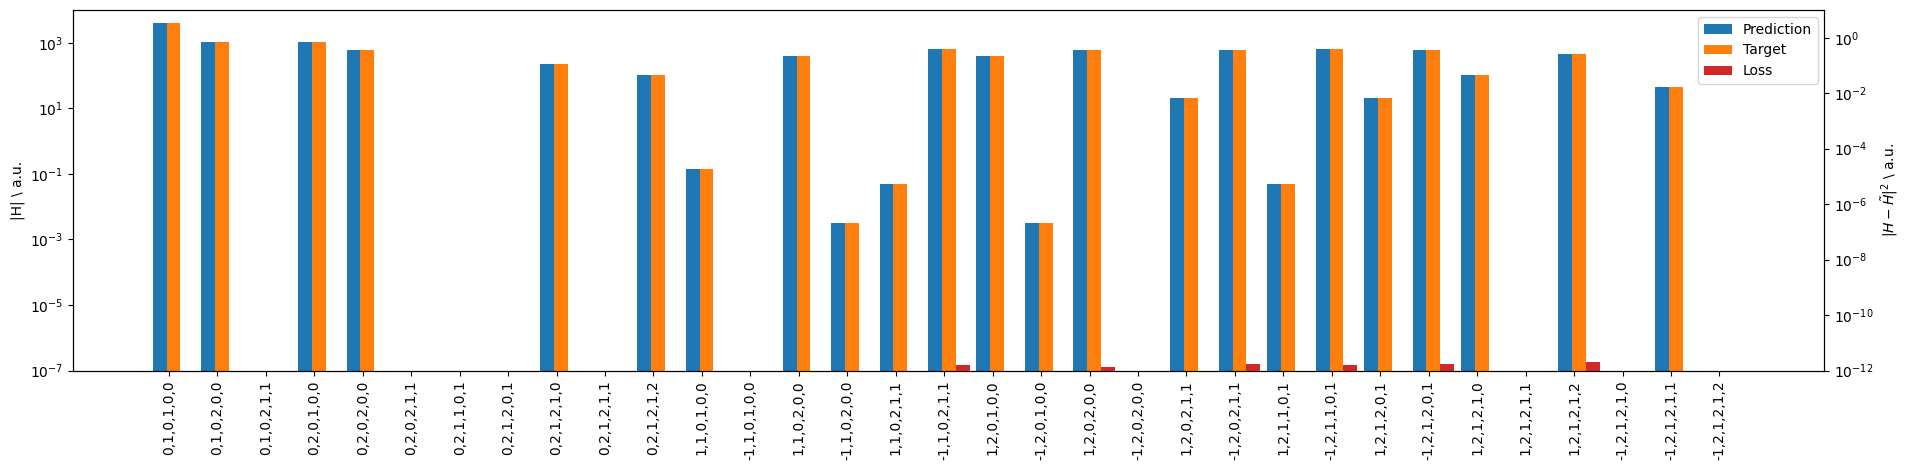

In [38]:
from mlelec.utils.plot_utils import plot_block_errors

fig, ax, ax_loss = plot_block_errors(target_test_fake, pred, plot_loss=True)
ax.set_ylim(1e-7, 1e4)
ax_loss.set_ylim(1e-12, 1e1)
fig.set_tight_layout(tight=True)
fig.savefig('blockerrors_hex22_pred.png')

In [40]:
rmat_hex22 = blocks_to_matrix(pred, fake_dataset)
actual_test = blocks_to_matrix(target_test_fake , fake_dataset)

In [43]:
err_mat = {}
for T in rmat_hex22[0]:
    err_mat[T] = rmat_hex22[0][T] - actual_test[0][T]

/tmp/ipykernel_230108/2168010072.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Greys')


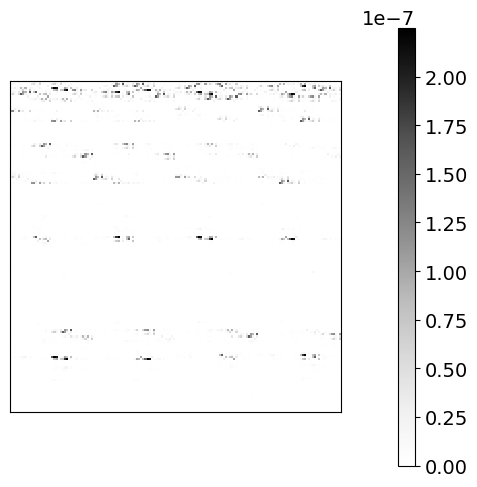

In [45]:
import matplotlib
fig, axes = plt.subplots(ncols = 2, gridspec_kw = {'width_ratios': [1,0.05]}, figsize = (5, 5.1))

cmap = matplotlib.cm.get_cmap('Greys')
ax = axes[0]
err_mat_ = np.array([err_mat[T].numpy() for T in err_mat])
x = np.abs(err_mat_.reshape(np.int32([np.sqrt(err_mat_.size), np.sqrt(err_mat_.size)])))
norm = matplotlib.colors.Normalize(vmin = 0, vmax = x.max())
ax.matshow(x, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1]
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap, norm = norm), ax)
fig.tight_layout()

fig.savefig('error_matrix_hex22.png')

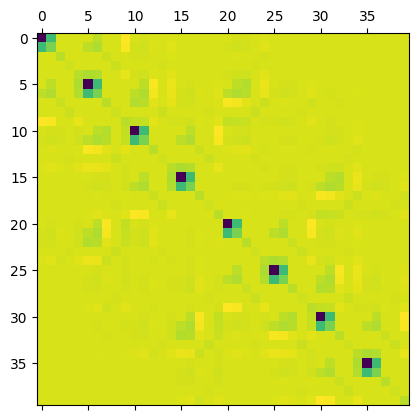

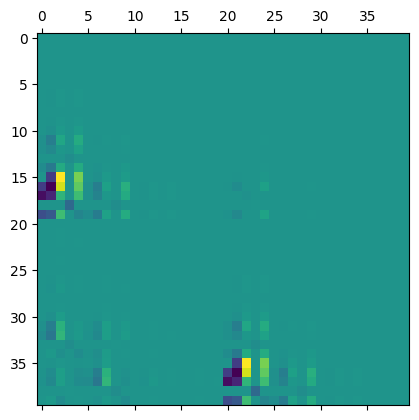

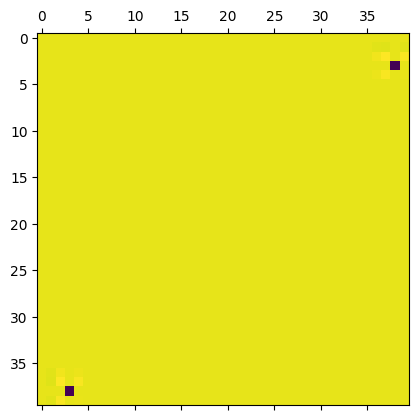

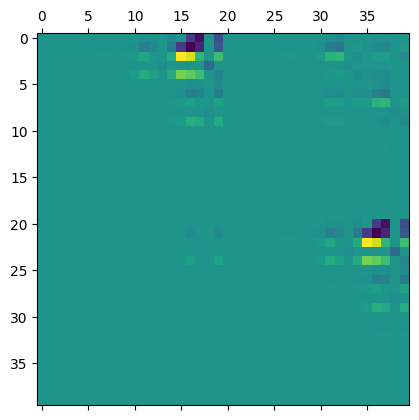

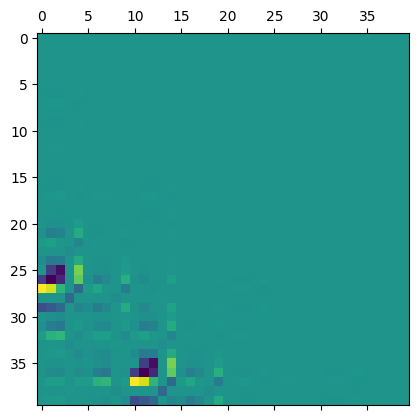

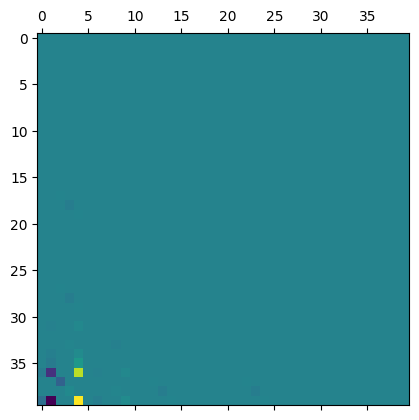

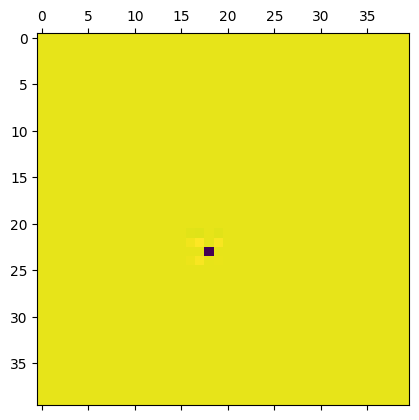

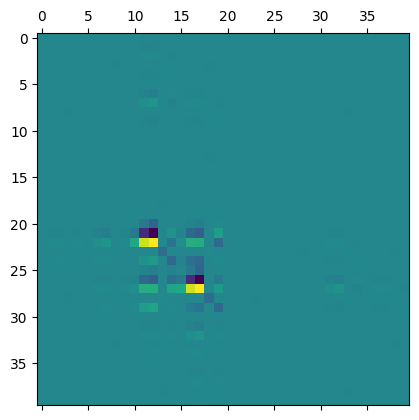

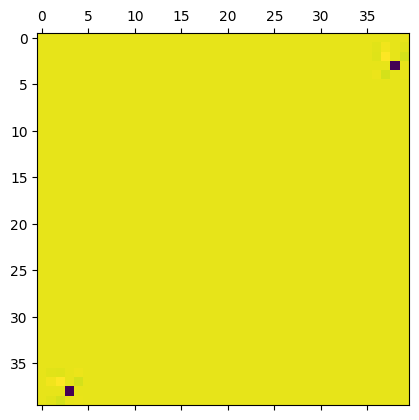

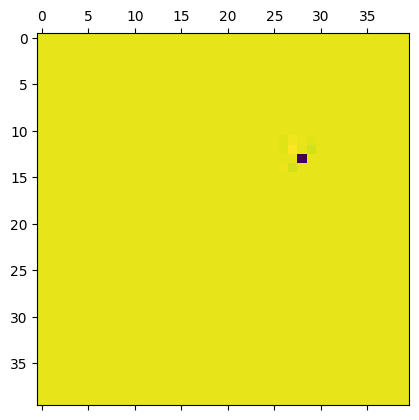

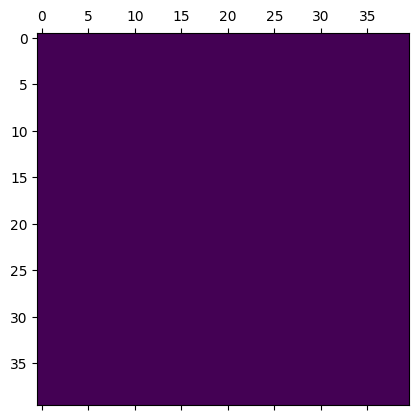

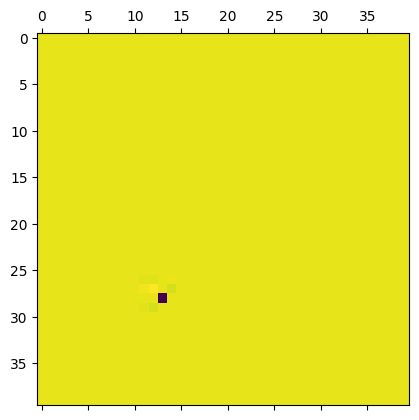

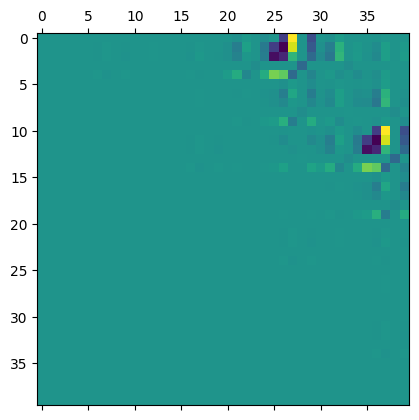

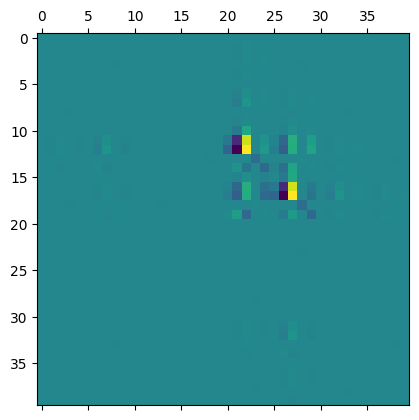

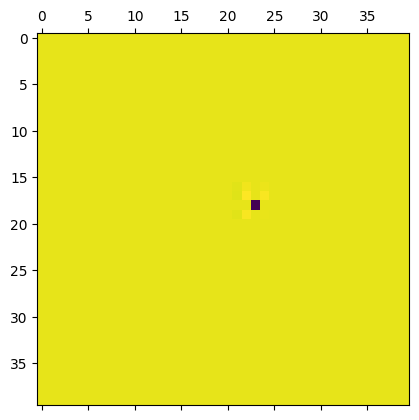

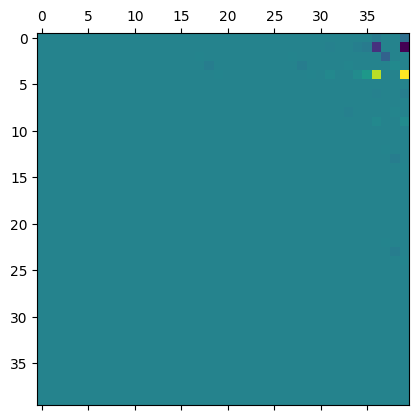

In [508]:
# for T in rmat_hex22[0]:
#     plt.matshow(rmat_hex22[0][T])

# Equivariance test 

In [8]:
workdir = '/home/nigam/scratch/MAC/k-hamiltonian/'
root = f'{workdir}/examples/data/periodic/c2/'
ORBS = 'sto-3g'
frames = read(f'{root}/C2_rotated.xyz', ':')
for f in frames: 
    f.pbc = True

kmesh = [8,8,1]

kfock = np.load(f"{root}/results_C2_rotated_881/kfocks.npy") 
kover = np.load(f"{root}/results_C2_rotated_881/kovers.npy") 

for ifr, frame in enumerate(frames):
    for ik, k in enumerate(kfock[ifr]):
        kfock[ifr][ik] = fix_orbital_order(k, frame, orbitals[ORBS]) #### TODO <<
        kover[ifr][ik] = fix_orbital_order(kover[ifr][ik], frame, orbitals[ORBS]) #### TODO <<

dataset = PySCFPeriodicDataset(frames = frames, kmesh = kmesh, fock_kspace = kfock, overlap_kspace = kover, device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)

In [9]:
cutoff = 6
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff)#, target='overlap')

In [10]:
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH

hypers_pair = {'cutoff': cutoff,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

hypers_atom = {'cutoff': 4,
               'max_radial': 10,
               'max_angular': 4,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}

return_rho0ij = False
both_centers = False
all_pairs = False
LCUT = 3

rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers, mic = True,
                      kmesh = dataset.kmesh, device="cpu", lcut = LCUT, return_rho0ij = return_rho0ij, counter = dataset._translation_counter, 
                      T_dict = dataset._translation_dict)

if both_centers and not return_rho0ij:
    NU = 3
else:
    NU = 2
rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = 'cpu',
                                feature_names = rhoij.property_names)

hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = True)

{'cutoff': 6, 'max_radial': 10, 'max_angular': 4, 'atomic_gaussian_width': 0.3, 'center_atom_weight': 1, 'radial_basis': {'Gto': {}}, 'cutoff_function': {'ShiftedCosine': {'width': 0.1}}}


/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/my_mlelec/src/mlelec/features/acdc.py:148: UserWarning: Using kmesh [[8, 8, 1], [8, 8, 1], [8, 8, 1]] for MIC mapping
  warnings.warn(f"Using kmesh {kmesh} for MIC mapping")


In [42]:
train_lbl = Labels(["structure"], values= np.array([[0,1]]).reshape(-1,1))
test_lbl= Labels(["structure"], values= np.array([[2]]).reshape(-1,1))
hfeat_train = mts_slice(hfeat, 'samples', train_lbl)
hfeat_test = mts_slice(hfeat, 'samples', test_lbl)
target_train = mts_slice(target_coupled_blocks, 'samples', train_lbl)
target_test = mts_slice(target_coupled_blocks, 'samples', test_lbl)

dataset_train = PySCFPeriodicDataset(frames = frames[:2], kmesh = [8,8,1], fock_kspace = kfock[:2], overlap_kspace = kover[:2], device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)
dataset_test = PySCFPeriodicDataset(frames = [frames[2]], kmesh = [8,8,1], fock_kspace = [kfock[2]], overlap_kspace = kover[2:], device = "cpu", orbs = orbitals[ORBS], orbs_name = ORBS)


In [43]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_train, 
                                  target_blocks = target_train,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_train,
                                                                         set_bias = True, 
                                                                        kernel_ridge = True)
print(loss_ridge_bias)

/home/nigam/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/nigam/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/nigam/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/nigam/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/nigam/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-d

tensor(4.7040e-07)


In [44]:
loss_blocks

{(0, 6, 1, 0, 6, 1, 0, 0): tensor(5.9418e-13),
 (0, 6, 1, 0, 6, 2, 0, 0): tensor(8.9285e-17),
 (0, 6, 1, 0, 6, 2, 1, 1): tensor(4.5835e-13),
 (0, 6, 2, 0, 6, 1, 0, 0): tensor(8.9285e-17),
 (0, 6, 2, 0, 6, 2, 0, 0): tensor(1.1467e-12),
 (0, 6, 2, 0, 6, 2, 1, 1): tensor(5.0635e-14),
 (0, 6, 2, 1, 6, 1, 0, 1): tensor(4.5835e-13),
 (0, 6, 2, 1, 6, 2, 0, 1): tensor(5.0635e-14),
 (0, 6, 2, 1, 6, 2, 1, 0): tensor(1.0025e-12),
 (0, 6, 2, 1, 6, 2, 1, 1): tensor(4.0783e-56),
 (0, 6, 2, 1, 6, 2, 1, 2): tensor(2.7565e-12),
 (1, 6, 1, 0, 6, 1, 0, 0): tensor(6.1358e-13),
 (-1, 6, 1, 0, 6, 1, 0, 0): tensor(3.7205e-28),
 (1, 6, 1, 0, 6, 2, 0, 0): tensor(1.0309e-12),
 (-1, 6, 1, 0, 6, 2, 0, 0): tensor(7.7484e-14),
 (1, 6, 1, 0, 6, 2, 1, 1): tensor(1.5766e-13),
 (-1, 6, 1, 0, 6, 2, 1, 1): tensor(1.0208e-11),
 (1, 6, 2, 0, 6, 1, 0, 0): tensor(1.0310e-12),
 (-1, 6, 2, 0, 6, 1, 0, 0): tensor(7.7484e-14),
 (1, 6, 2, 0, 6, 2, 0, 0): tensor(3.4099e-12),
 (-1, 6, 2, 0, 6, 2, 0, 0): tensor(1.5990e-27),
 (1, 6, 

In [46]:
from mlelec.utils.twocenter_utils import map_targetkeys_to_featkeys
pred_blocks = []
dummy_property = target_coupled_blocks[0].properties
targetkeynames = target_coupled_blocks.keys.names

for imdl, (key, tkey) in enumerate(zip(model_ridge.model, target_test.keys )):
    target = target_test.block(tkey)
    nsamples, ncomp, nprops = target.values.shape

    feat = map_targetkeys_to_featkeys(hfeat_test, tkey)
    x = ((feat.values.reshape((feat.values.shape[0] * feat.values.shape[1], -1))/1).cpu().numpy())
    pred = ridges_bias[imdl].predict(x) # kernel ridge automatically computes the kernel
    assert np.all(feat.samples.values[:,:6] == target.samples.values), (feat.samples.values[:,:6], target.samples.values)
    pred_blocks.append(
                    TensorBlock(
                        values = torch.from_numpy(pred.reshape((nsamples, ncomp, 1))).to(device),
                        samples = target.samples,
                        components = target.components,
                        properties = dummy_property,
                        )
    )

pred = TensorMap(target_test.keys, pred_blocks)

In [47]:
loss = {}
for (k, tb) in target_test.items():
        feat = map_targetkeys_to_featkeys(hfeat_test, k)
        loss[tuple(k)]= torch.norm(tb.values - pred.block(k).values)**2
        print(' '.join([f'{key:>2d}' for key in k.values]), f'f: {torch.linalg.norm(feat.values):>10.6f} | \
        t: {torch.norm(tb.values):>10.6f} | \
        p: {torch.norm(pred.block(k).values):>10.6f} | loss: {torch.sum((tb.values - pred.block(k).values)**2):>10.6f}' )

print('LOSS:', sum(loss.values()))

 0  6  1  0  6  1  0  0 f:   5.128539 |         t: 124.671777 |         p: 124.671775 | loss:   0.000000
 0  6  1  0  6  2  0  0 f:   5.128539 |         t:  33.670924 |         p:  33.670924 | loss:   0.000000
 0  6  1  0  6  2  1  1 f:   0.464411 |         t:   0.008560 |         p:   0.008559 | loss:   0.000000
 0  6  2  0  6  1  0  0 f:   5.128539 |         t:  33.670924 |         p:  33.670924 | loss:   0.000000
 0  6  2  0  6  2  0  0 f:   5.128539 |         t:  19.907622 |         p:  19.907620 | loss:   0.000000
 0  6  2  0  6  2  1  1 f:   0.464411 |         t:   0.241592 |         p:   0.241592 | loss:   0.000000
 0  6  2  1  6  1  0  1 f:   0.464411 |         t:   0.008560 |         p:   0.008559 | loss:   0.000000
 0  6  2  1  6  2  0  1 f:   0.464411 |         t:   0.241592 |         p:   0.241592 | loss:   0.000000
 0  6  2  1  6  2  1  0 f:   5.128539 |         t:   9.543351 |         p:   9.543349 | loss:   0.000000
 0  6  2  1  6  2  1  1 f:   0.010079 |         t:   0.

In [63]:
_, test_blocks = get_targets(dataset_test, cutoff = 6)
error_matrix(pred_zeroidx, test_blocks, dataset_test)

tensor(4.2845e-06)

In [64]:
pred_zeroidx = renumber_samples(pred)
rmat_test = blocks_to_matrix(pred_zeroidx, dataset_test)
actual_test  = blocks_to_matrix(test_blocks, dataset_test)

In [65]:
err_mat = {}
for T in rmat_test[0]:
    err_mat[T] = rmat_test[0][T] - actual_test[0][T]

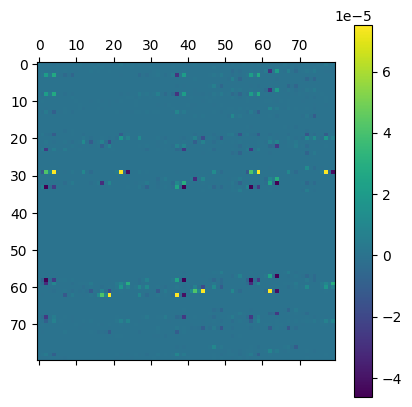

In [66]:
err_mat_ = np.array([err_mat[T].numpy() for T in err_mat])
plt.matshow(err_mat_.reshape(np.int32([np.sqrt(err_mat_.size), np.sqrt(err_mat_.size)])))
plt.colorbar()

/tmp/ipykernel_229133/2701026450.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Greys')


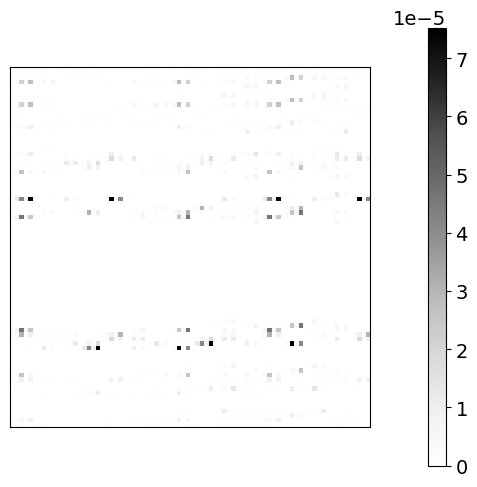

In [80]:
import matplotlib
fig, axes = plt.subplots(ncols = 2, gridspec_kw = {'width_ratios': [1,0.05]}, figsize = (5, 5.1))

cmap = matplotlib.cm.get_cmap('Greys')
ax = axes[0]
err_mat_ = np.array([err_mat[T].numpy() for T in err_mat])
x = np.abs(err_mat_.reshape(np.int32([np.sqrt(err_mat_.size), np.sqrt(err_mat_.size)])))
norm = matplotlib.colors.Normalize(vmin = 0, vmax = x.max())
ax.matshow(x, cmap = cmap)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1]
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap, norm = norm), ax)
fig.tight_layout()

fig.savefig('error_matrix_rotation_test.png')